In [62]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [63]:
# reading the data
dataset = pd.read_csv('costsensitiveregression.csv')

In [64]:
dataset.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [65]:
# checking the statistics of the False Negative Cost
dataset['FNC'].describe()

count    1.476360e+05
mean     5.334049e+02
std      8.774011e+03
min      0.000000e+00
25%      2.820820e-01
50%      1.183562e+01
75%      1.069840e+02
max      1.703186e+06
Name: FNC, dtype: float64

In [66]:
# Splitting the data

X = dataset[['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN']]
Y = dataset['Status']
FN = dataset['FNC']

In [67]:
# converting into torch tensors from Pandas

X_ten = torch.tensor(X.values, dtype=torch.float32)
Y_ten = torch.tensor(Y.values, dtype=torch.float32)

TP_ten = torch.tensor([4 for i in range(len(Y_ten))], dtype=torch.float32)
FP_ten = torch.tensor([4 for i in range(len(TP_ten))], dtype=torch.float32)
TN_ten = torch.tensor([0 for i in range(len(TP_ten))], dtype=torch.float32)
FN_ten = torch.tensor(FN.values, dtype=torch.float32)


In [68]:
# performing test-train 80-20
indices = np.arange(len(dataset) , dtype = np.int64)
np.random.shuffle(indices)

train_indices = indices[:int(len(dataset)*0.8)].tolist()
test_indices = indices[int(len(dataset)*0.8):].tolist()

In [69]:
X_train = X_ten[train_indices]
Y_train = Y_ten[train_indices].reshape(-1,1)
X_test = X_ten[test_indices]
Y_test = Y_ten[test_indices].reshape(-1,1)

TP_train = TP_ten[train_indices].reshape(-1,1)
TP_test = TP_ten[test_indices].reshape(-1,1)
FP_train = FP_ten[train_indices].reshape(-1,1)
FP_test = FP_ten[test_indices].reshape(-1,1)
TN_train = TN_ten[train_indices].reshape(-1,1)
TN_test = TN_ten[test_indices].reshape(-1,1)
FN_train = FN_ten[train_indices].reshape(-1,1)
FN_test = FN_ten[test_indices].reshape(-1,1)

# # we want to normalize the False negative cost values to values between 0 and 5 
# # since other costs are approximately equal to 4 
# # we normalize the testing set also using training set values
FN_train_max = torch.max(FN_train)
FN_train_min = torch.min(FN_train)

FN_train = (FN_train - FN_train_min)/(FN_train_max - FN_train_min) * 5
FN_test= (FN_test - FN_train_min)/(FN_train_max - FN_train_min) * 5

# using these normalized FN as a feature
X_train = torch.hstack((X_train, FN_train))
X_test = torch.hstack((X_test, FN_test))

In [70]:
class LogisticRegression(nn.Module):
    def __init__(self , input_dim , output_dim):
        super(LogisticRegression, self).__init__()
        
        # creating a one layer Neural Network
        self.fc1 = nn.Linear(input_dim , output_dim)

        # initializing the weights: since we find random initialization of the weights
        # had significant impact on the results, we use kaiming uniform initialization
        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        
    def forward(self, x):
        # appllying sigmoid to output to convert into probability
        return torch.sigmoid(self.fc1(x))

In [134]:
def CostSensitiveLoss(y, y_hat, tp, fp, fn, tn):
    loss = torch.mean(y * (y_hat * tp + (1 - y_hat) * fn) + (1 - y) * (y_hat * fp + (1 - y_hat) * tn))
    loss.requires_grad_()
    return loss

Epoch 1/40 : Train Loss = 1.6316 , Test Loss = 1.6151
Epoch 2/40 : Train Loss = 1.6104 , Test Loss = 1.5944
Epoch 3/40 : Train Loss = 1.5898 , Test Loss = 1.5743
Epoch 4/40 : Train Loss = 1.5699 , Test Loss = 1.5548
Epoch 5/40 : Train Loss = 1.5506 , Test Loss = 1.5359
Epoch 6/40 : Train Loss = 1.5319 , Test Loss = 1.5175
Epoch 7/40 : Train Loss = 1.5137 , Test Loss = 1.4997
Epoch 8/40 : Train Loss = 1.4962 , Test Loss = 1.4825
Epoch 9/40 : Train Loss = 1.4791 , Test Loss = 1.4657
Epoch 10/40 : Train Loss = 1.4625 , Test Loss = 1.4494
Epoch 11/40 : Train Loss = 1.4464 , Test Loss = 1.4335
Epoch 12/40 : Train Loss = 1.4307 , Test Loss = 1.4181
Epoch 13/40 : Train Loss = 1.4155 , Test Loss = 1.4031
Epoch 14/40 : Train Loss = 1.4006 , Test Loss = 1.3884
Epoch 15/40 : Train Loss = 1.3862 , Test Loss = 1.3742
Epoch 16/40 : Train Loss = 1.3721 , Test Loss = 1.3603
Epoch 17/40 : Train Loss = 1.3583 , Test Loss = 1.3467
Epoch 18/40 : Train Loss = 1.3449 , Test Loss = 1.3335
Epoch 19/40 : Train

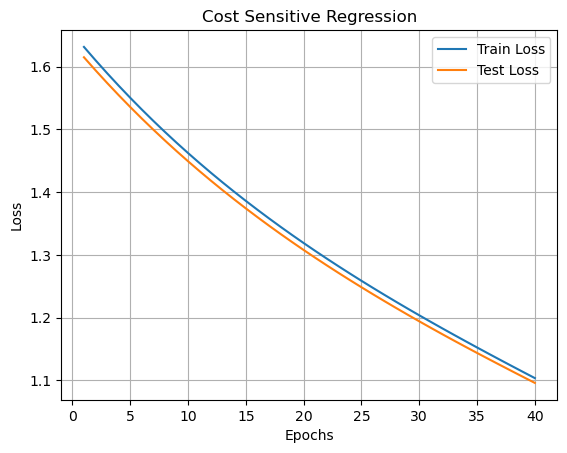

In [135]:
epochs = 40
tp = 4          # true positive cost
fp = 4          # false positive cost
tn = 0          # true negative cost
train_losses = []
test_losses = []
model = LogisticRegression(12 , 1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = CostSensitiveLoss(Y_train, y_hat_probs, TP_train, FP_train, FN_train, TN_train)
    
    # setting the gradients to zero
    optimizer.zero_grad()
    # calculating the gradients using backpropagation
    loss.backward()
    # updating the weights
    optimizer.step()

    # appending the training loss
    train_losses.append(loss.item())

    # testing loss
    y_hat_probs_test = model(X_test)
    Y_hat_test = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_probs_test], dtype=torch.float32)
    loss_test = CostSensitiveLoss(Y_test, y_hat_probs_test, TP_test, FP_test, FN_test, TN_test)
    test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs} : Train Loss = {loss.item():.4f} , Test Loss = {loss_test.item():.4f}')

# plotting the losses vs epochs
ticks = [i for i in range(1, epochs+1)]
plt.title('Cost Sensitive Regression')
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [136]:
# calculating the accuracy
y_hat_cost_sensitive = model(X_test)
Y_hat_cost_sensitive = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_cost_sensitive], dtype=torch.float32).reshape(-1,1)
print("Accuracy is {}".format((Y_hat_cost_sensitive == Y_test).sum().item()/len(Y_test) * 100))

Accuracy is 86.64318612842048


In [71]:
def NormalLoss(y, y_hat):
    loss = torch.mean(y * (1 - y_hat) + (1 - y) * y_hat)
    loss.requires_grad_()
    return loss

Epoch 1/40 : Train Loss = 0.8555 , Test Loss = 2.7792
Epoch 2/40 : Train Loss = 0.8547 , Test Loss = 2.7636
Epoch 3/40 : Train Loss = 0.8538 , Test Loss = 2.7476
Epoch 4/40 : Train Loss = 0.8528 , Test Loss = 2.7313
Epoch 5/40 : Train Loss = 0.8517 , Test Loss = 2.7145
Epoch 6/40 : Train Loss = 0.8505 , Test Loss = 2.6973
Epoch 7/40 : Train Loss = 0.8492 , Test Loss = 2.6796
Epoch 8/40 : Train Loss = 0.8478 , Test Loss = 2.6613
Epoch 9/40 : Train Loss = 0.8462 , Test Loss = 2.6425
Epoch 10/40 : Train Loss = 0.8445 , Test Loss = 2.6230
Epoch 11/40 : Train Loss = 0.8427 , Test Loss = 2.6029
Epoch 12/40 : Train Loss = 0.8407 , Test Loss = 2.5819
Epoch 13/40 : Train Loss = 0.8386 , Test Loss = 2.5602
Epoch 14/40 : Train Loss = 0.8362 , Test Loss = 2.5376
Epoch 15/40 : Train Loss = 0.8337 , Test Loss = 2.5140
Epoch 16/40 : Train Loss = 0.8309 , Test Loss = 2.4893
Epoch 17/40 : Train Loss = 0.8279 , Test Loss = 2.4636
Epoch 18/40 : Train Loss = 0.8247 , Test Loss = 2.4366
Epoch 19/40 : Train

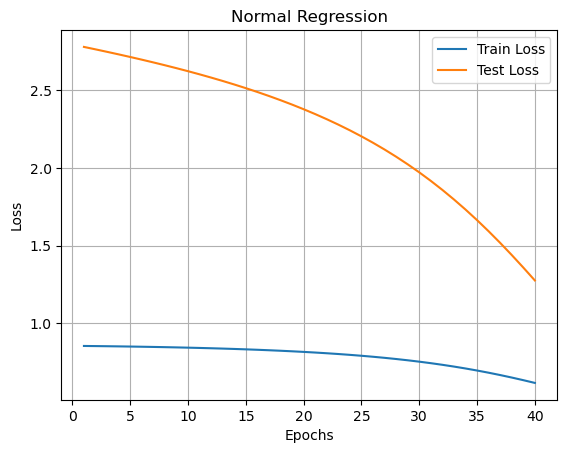

In [85]:
epochs = 40

train_losses = []
test_losses = []
model = LogisticRegression(12 , 1)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = NormalLoss(Y_train, y_hat_probs)
    
    # setting the gradients to zero
    optimizer.zero_grad()
    # calculating the gradients using backpropagation
    loss.backward()
    # updating the weights
    optimizer.step()

    # appending the training loss
    train_losses.append(loss.item())

    # testing loss
    y_hat_probs_test = model(X_test)
    Y_hat_test = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_probs_test], dtype=torch.float32)
    loss_test = CostSensitiveLoss(Y_test, y_hat_probs_test, TP_test, FP_test, FN_test, TN_test)
    test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs} : Train Loss = {loss.item():.4f} , Test Loss = {loss_test.item():.4f}')

# plotting the losses vs epochs
ticks = [i for i in range(1, epochs+1)]
plt.title('Normal Regression')
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [86]:
# calculating the accuracy
y_hat_normal = model(X_test)
Y_hat_normal = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_normal], dtype=torch.float32).reshape(-1,1)
print("Accuracy is {}".format((Y_hat_normal == Y_test).sum().item()/len(Y_test) * 100))

Accuracy is 35.559468978596584


In [87]:
# calcuaalting the number of misclassifications

TP_cost_sensitive = 0
FP_cost_sensitive = 0
TN_cost_sensitive = 0
FN_cost_sensitive = 0

TP_normal = 0
FP_normal = 0
TN_normal = 0
FN_normal = 0

for i in range(len(Y_test)):

    if Y_test[i]:
        if Y_hat_cost_sensitive[i]:
            TP_cost_sensitive += 1
        else:
            FN_cost_sensitive += 1

        if Y_hat_normal[i]:
            TP_normal += 1
        else:
            FN_normal += 1

    else:
        if Y_hat_cost_sensitive[i]:
            FP_cost_sensitive += 1
        else:
            TN_cost_sensitive += 1

        if Y_hat_normal[i]:
            FP_normal += 1
        else:
            TN_normal += 1
        

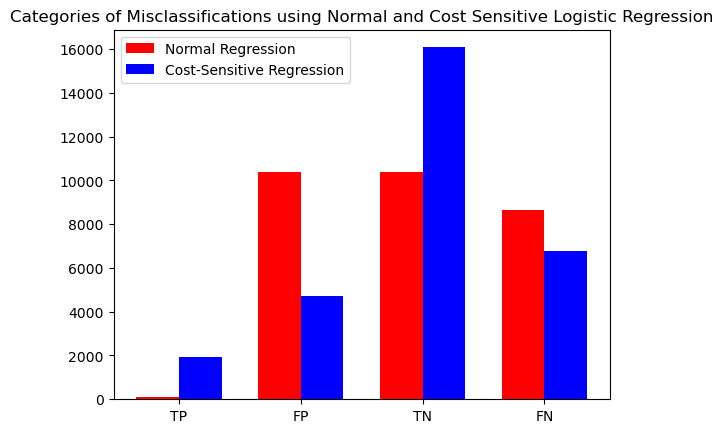

In [88]:
# comparing the number of misclassifcations for normal and cost sensitive regression

bar1 = [TP_normal, FP_normal, TN_normal, FN_normal]
bar2 = [TP_cost_sensitive, FP_cost_sensitive, TN_cost_sensitive, FN_cost_sensitive]

br1 = np.arange(4)
width = 0.35
br2 = [x + width for x in br1]

plt.bar(br1, bar1, color ='r', width = width, label ='Normal Regression')
plt.bar(br2, bar2, color ='b', width = width,  label ='Cost-Sensitive Regression')
plt.legend()
plt.xticks([x - width/2 for x in br2], ['TP', 'FP', 'TN', 'FN'])
plt.title("Categories of Misclassifications using Normal and Cost Sensitive Logistic Regression")
plt.show()